In [70]:
import gensim
from loveisland.common.functions import Functions as F
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [71]:
PALETTE = F.get_palette()
ORIGINAL_ISLANDERS = F.get_islanders()

In [72]:
class PrepData:
    def __init__(self):
        self.df = None

    def import_df(self, col="date", last="2019-06-02"):
        self.df = F.import_all()
        self.df = self.df[self.df[col] <= last]
        return self

    def format_cols(self):
        self.df["tokens"] = self.df["tokens"].apply(lambda x: F.str_to_list(x))
        self.df["islanders"] = self.df["islanders"].apply(lambda x: F.str_to_list(x))
        return self

    def ngrams(self, col="tokens"):
        ngram = gensim.models.Phrases(self.df[col])
        self.df[col] = self.df[col].apply(lambda x: ngram[x])
        self.df[col] = self.df[col].apply(lambda x: [i.replace(" ", "") for i in x])
        return self


class AggFunctions:
    def get_ngrams(self, df, col="tokens"):
        df["inc_ngram"] = df[col].apply(lambda x: "yes" if "_" in x else "no")
        return [i for i in self.get_tokens(df) if "_" in i and "status" not in i]

    @staticmethod
    def get_counts(tokens):
        counts = pd.DataFrame.from_dict(
            Counter(tokens), orient="index", columns=["count"]
        )
        counts.index.name = "token"
        return (
            counts.reset_index()
            .sort_values("count", ascending=False)
            .reset_index(drop=True)
        )

    def count_df(self, df, group):
        df = (
            df.groupby(group)["url"]
            .count()
            .reset_index(name="count")
            .sort_values(by=group, ascending=True)
        )
        return self.format_date(df)

    @staticmethod
    def format_date(df, col="date"):
        if "date" in df.columns:
            df["date"] = df["date"].astype(str)
        return df.reset_index(drop=False)

    def inc_islander(self, df, col="islanders"):
        df[col] = df[col].apply(lambda x: [i for i in x if i in ORIGINAL_ISLANDERS])
        df["inc_islander"] = np.where(df[col].str.len() < 1, "No", "Yes")
        df = self.count_df(df, ["date", "inc_islander"])
        df["perc"] = df.groupby(["date"])["count"].apply(lambda x: x * 100 / sum(x))
        return df[df["inc_islander"] == "Yes"]

    @staticmethod
    def islander_counts(df):
        counts = df.count()
        counts.index.name = "islander"
        counts = counts.reset_index(name="count")
        return counts[counts["islander"].isin(ORIGINAL_ISLANDERS)].reset_index(
            drop=True
        )

    @staticmethod
    def get_tokens(df, col="tokens"):
        return [item for sublist in df[col].to_list() for item in sublist]

    def get_token_df(self, df, date, col="tokens"):
        n = df.url.nunique()
        df = self.get_counts(self.get_tokens(df, col))
        df["n_tweets"] = n
        df["date"] = date
        df["percent"] = df["count"] / sum(df["count"])
        return df

    @staticmethod
    def most_pop(df):
        return (
            df[~df["text"].str.contains("pic")]
            .sort_values("favs", ascending=False)
            .groupby("date")
            .head(1)
            .sort_values("date", ascending=True)
            .reset_index(drop=True)
        )


In [73]:
af = AggFunctions()

In [74]:
prd = PrepData()
prd.import_df().format_cols().ngrams().ngrams()

df = prd.df.copy()

[Text(0, 0.5, 'Number of Tweets'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Number of tweets per day about love island in the two weeks prior to the first episode')]

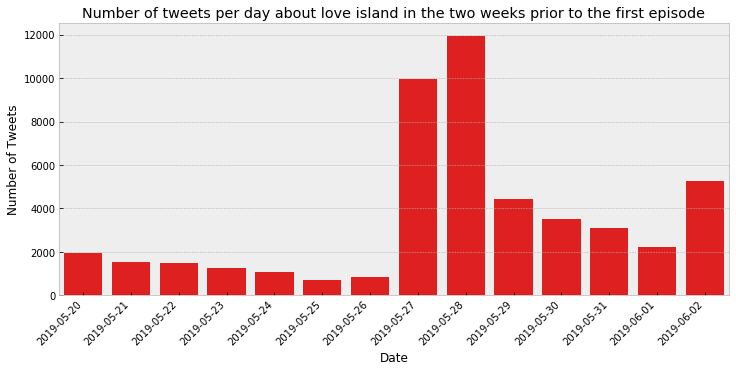

In [75]:
to_plot = af.count_df(df, "date")
to_plot["date"] = to_plot["date"].astype(str)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "count", data=to_plot, color="Red", ax=ax1)

plt.xticks(rotation=45, ha="right")
ax1.set(
    xlabel="Date",
    ylabel="Number of Tweets",
    title="Number of tweets per day about love island in the two weeks prior to the first episode",
);

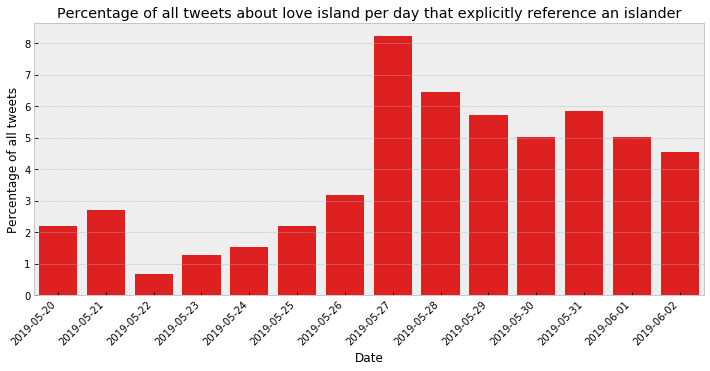

In [76]:
to_plot = af.inc_islander(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "perc", data=to_plot, ax=ax1, color="Red")

plt.xticks(rotation=45, ha="right")
ax1.set(
    xlabel="Date",
    ylabel="Percentage of all tweets",
    title="Percentage of all tweets about love island per day that explicitly reference an islander",
);

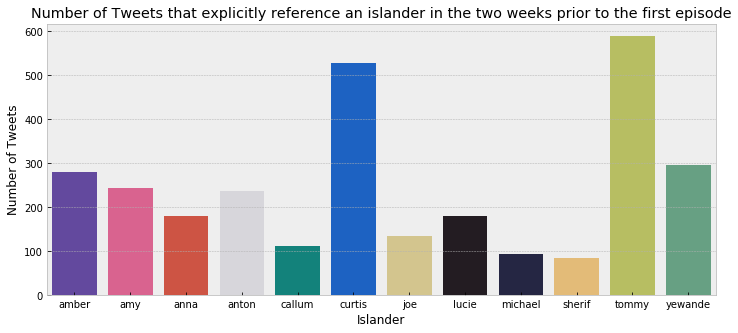

In [77]:
to_plot = af.islander_counts(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot(
    "islander", "count", "islander", data=to_plot, ax=ax1, palette=PALETTE, dodge=False
)

plt.legend().remove()
ax1.set(
    xlabel="Islander",
    ylabel="Number of Tweets",
    title="Number of Tweets that explicitly reference an islander in the two weeks prior to the first episode",
);

In [78]:
n_grams = af.get_ngrams(df)
counts = af.get_counts(n_grams)
counts.head(15)

,token,count
0,not_wait,931
1,mental_health,579
2,plus_size,566
3,start_tomorrow,462
4,tommy_fury,415
5,new_cast,393
6,body_diversity,337
7,utm_medium_social_utm,312
8,new_series,308
9,new_contestant,303


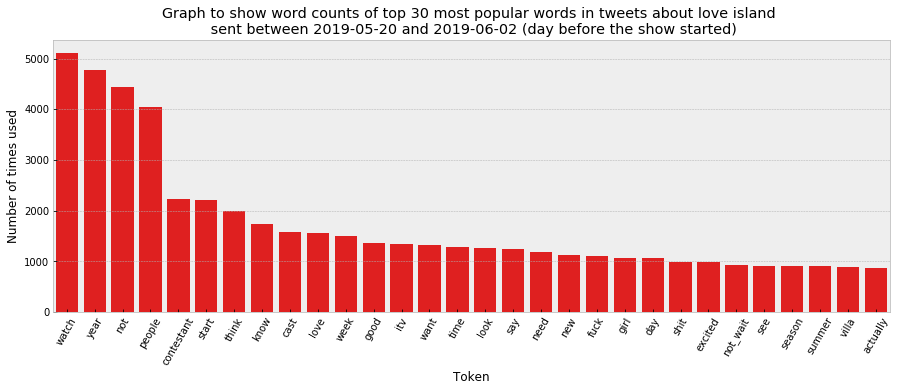

In [79]:
to_plot = af.get_token_df(df, "all")

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

sns.barplot("token", "count", data=to_plot.head(30), color="Red", ax=ax1)

plt.xticks(rotation=60)
ax1.set(
    xlabel="Token",
    ylabel="Number of times used",
    title="Graph to show word counts of top 30 most popular words in tweets about love island \n \
sent between 2019-05-20 and 2019-06-02 (day before the show started)",
);

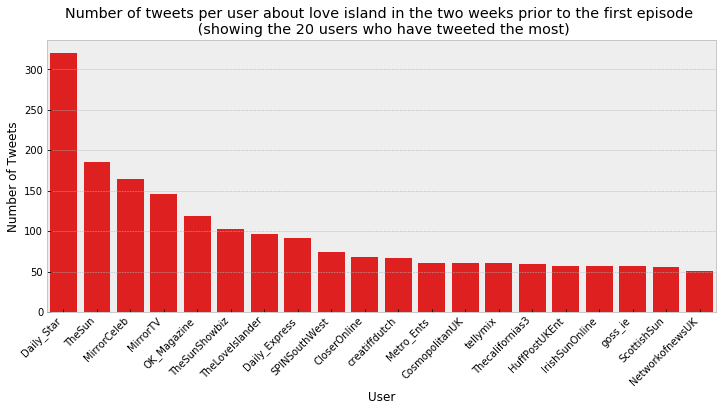

In [80]:
to_plot = af.count_df(df, "user")
to_plot = to_plot.sort_values("count", ascending=False).head(20)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("user", "count", data=to_plot, color="Red", ax=ax1)

plt.xticks(rotation=45, ha="right")
ax1.set(
    xlabel="User",
    ylabel="Number of Tweets",
    title="Number of tweets per user about love island in the two weeks prior to the first episode \n \
(showing the 20 users who have tweeted the most)",
);

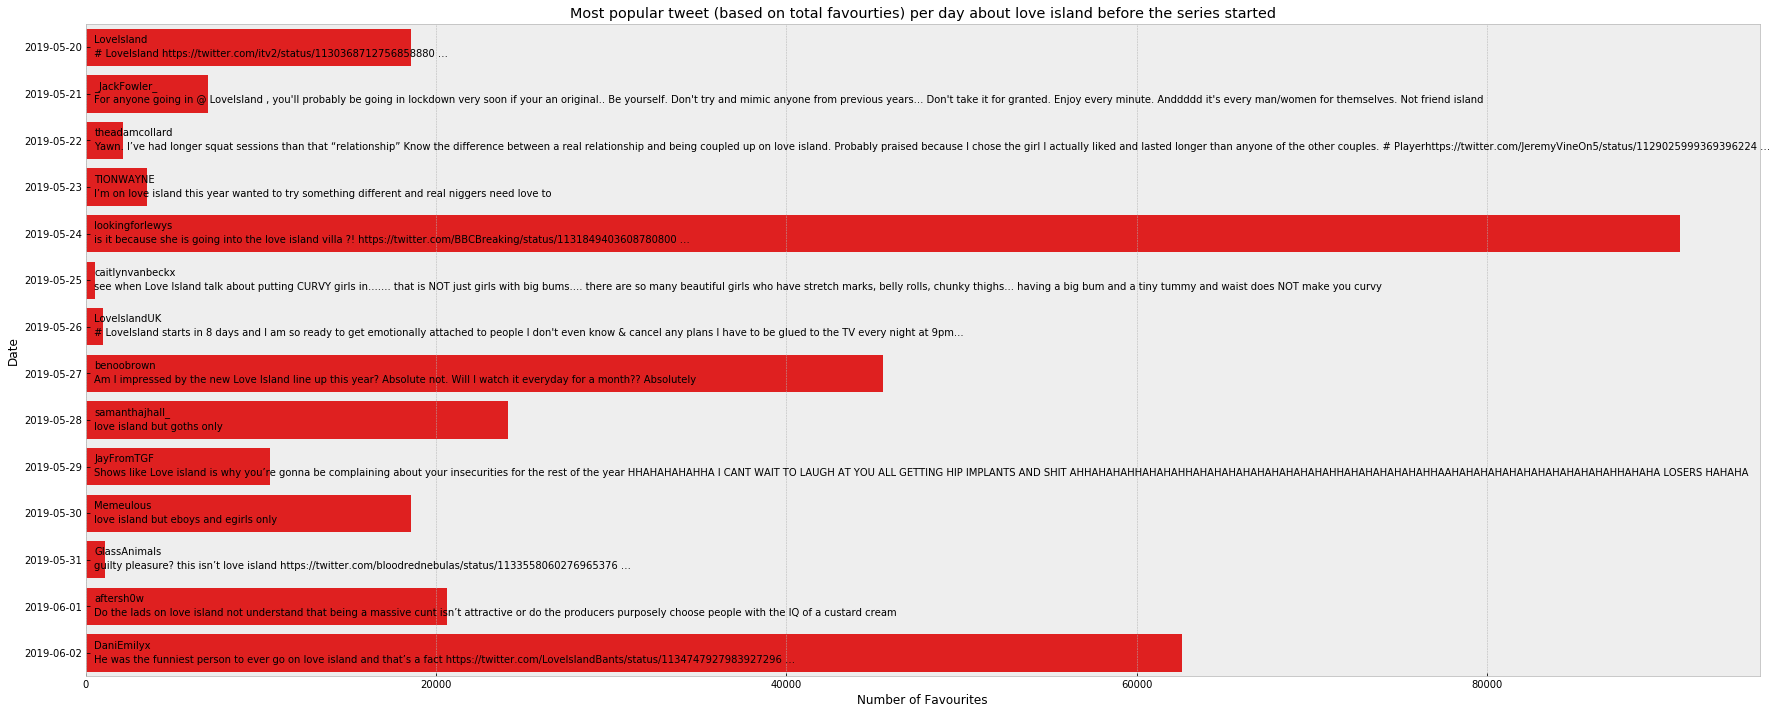

In [81]:
df["text"] = df["text"].astype(str)
to_plot = af.most_pop(df)
to_plot["date"] = to_plot["date"].astype(str)

fig = plt.figure(figsize=(30, 12))
ax1 = fig.add_subplot(111)

sns.barplot("favs", "date", data=to_plot, color="Red", ax=ax1)

for i, row in to_plot.iterrows():
    ax1.annotate(row["text"], xy=(0, 0), xytext=(500, i + 0.2))
    ax1.annotate(row["user"], xy=(0, 0), xytext=(500, i - 0.1))

ax1.set(
    xlabel="Number of Favourites",
    ylabel="Date",
    title="Most popular tweet (based on total favourties) per day about love island before the series started",
);